In [1]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Introduction**

This notebook contains the code necessary for the collection and cleaning of three different datasets: political data, COVID data, and Yelp review data.

## **Collecting and Cleaning State Political Data**

This DataFrame, sourced from county–level political data via Harvard DataVerse, will contain each state's political "affilitation", based on the results from the 2020 United States Presidential Election.

This DataFrame will be used for all of the political–based research questions that we have in mind, in conjunction with the COVID data that we have sourced.

In [2]:
# bring in the results from the 2020 presidential election (from source #3 -> US President 1976–2020)
# codebook: https://dataverse.harvard.edu/api/access/datafile/4299754 
df_us_pe_2020 = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/4299753?format=original&gbrecs=true') # had to pull this link from dev tools
df_us_pe_2020 = df_us_pe_2020[df_us_pe_2020["year"] == 2020].reset_index(drop=True)

# create a DataFrame that has state and party OVERALL (the one that has the most votes within the state)
df_us_pe_2020["votes_normalized"] = df_us_pe_2020["candidatevotes"].divide(df_us_pe_2020["totalvotes"])
max_votes_idx = df_us_pe_2020.groupby("state")["votes_normalized"].transform(max) == df_us_pe_2020["votes_normalized"]
state_party = df_us_pe_2020[max_votes_idx][["state", "party_simplified"]].reset_index(drop=True)

state_party.head()

,state,party_simplified
0,ALABAMA,REPUBLICAN
1,ALASKA,REPUBLICAN
2,ARIZONA,DEMOCRAT
3,ARKANSAS,REPUBLICAN
4,CALIFORNIA,DEMOCRAT


In [3]:
# export this to a CSV for use in other notebooks
state_party.to_csv('/content/drive/MyDrive/DATA 301 Final Project Group 2/df_state_party.csv')

## **Cleaning and Collecting COVID Case, Death, and Vaccination Data**

This DataFrame, built with data sourced from the New York Times, United States' Census API, and the Center for Systems Science and Engineering at Johns Hopkins University, contains time-series, county–level COVID case, death, and vaccination data, as well as county–level population data. 

This DataFrame will be the basis for all of our COVID–related analyses, and will be combined with the political DataFrame from above when necessary.

In [4]:
# County level covid cases and deaths time-series data
df_casesAndDeathsCounty = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv")

In [5]:
# United States County level Census data
response = requests.get("https://api.census.gov/data/2019/pep/population?get=NAME,POP&for=county:*&in=state:*&key=da85b389c3133074f31309c55a66b97c0dc20da2")

In [6]:
df_census = pd.DataFrame(response.json(), columns=["NAME", "POP", "state", "county"]).drop(0).reset_index(drop=True)

# grab inidividual county and state names 
df_census["NAME"] = df_census["NAME"].str.split(", ")
df_census["CountyName"] = df_census["NAME"].str[0].str.replace("County", "").str.replace("Parish", "").str.replace("Municipality", "").str.strip()
df_census["POP"] = df_census["POP"].astype(float)
df_census["StateName"] = df_census["NAME"].str[1]
df_census = df_census[df_census["StateName"] != "Puerto Rico"]
df_census.drop(["NAME", "state", "county"], axis=1, inplace=True)

# Fix New York City data for correct merge
NYCSeries = pd.Series(
    {"CountyName":"New York City",
    "POP":(df_census.set_index(["StateName", "CountyName"]).loc["New York", "Bronx"]["POP"] + 
            df_census.set_index(["StateName", "CountyName"]).loc["New York", "New York"]["POP"] + 
          df_census.set_index(["StateName", "CountyName"]).loc["New York", "Kings"]["POP"] + 
          df_census.set_index(["StateName", "CountyName"]).loc["New York", "Richmond"]["POP"]), 
     "StateName":"New York"})
df_census = df_census.append(NYCSeries, ignore_index=True)
df_census.set_index("CountyName", inplace=True)
df_census = df_census.drop(["Bronx", "Queens", "New York", "Kings", "Richmond"])
df_census.reset_index(inplace=True)

# Merge census and cases/deaths data
df_countyStats = pd.merge(left=df_casesAndDeathsCounty, right = df_census, left_on=["county", "state"], right_on=["CountyName", "StateName"], how="inner")
df_countyStats.drop(["CountyName", "StateName"], inplace=True, axis=1)

In [7]:
# Vaccination data by state:
df_vaccinesState = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv")
df_vaccinesState["location"] = df_vaccinesState["location"].str.replace("New York State", "New York")

# Merge census, cases/deaths data, and vaccination data
df_countyStateStats = pd.merge(left=df_countyStats, right = df_vaccinesState, left_on=["state", "date"], right_on=["location", "date"], how="left").drop(
    ["location", "people_fully_vaccinated_per_hundred", "total_vaccinations_per_hundred", "people_vaccinated_per_hundred", "daily_vaccinations_per_million", 
     "distributed_per_hundred", "daily_vaccinations_raw"], axis=1)
df_countyStateStats = df_countyStateStats.rename(columns={"total_vaccinations":"state_tot_vacinnations", "total_distributed":"state_tot_distributed", 
                                                          "people_vaccinated":"state_people_vaccinated", "people_fully_vaccinated":"state_people_fully_vaccinated",
                                                          "daily_vaccinations":"state_daily_vaccinations", "share_doses_used":"state_share_doses_used", "POP":"countyPopulation"})

In [8]:
df_countyStateStats.head()
# NaN vaccination data for dates before a vaccine was available

,date,county,state,fips,cases,deaths,countyPopulation,state_tot_vacinnations,state_tot_distributed,state_people_vaccinated,state_people_fully_vaccinated,state_daily_vaccinations,state_share_doses_used
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,822083.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,822083.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,822083.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,822083.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,822083.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# export this for use in other notebooks
df_countyStateStats.to_csv('/content/drive/MyDrive/DATA 301 Final Project Group 2/df_covid_stats_us_county.csv')

## **Collecting and Cleaning Yelp Review Data**

This DataFrame, built with data sourced from the Yelp API, contains Yelp restaurant reviews from the years 2019, 2020, 2021.

This DataFrame will be used to give our group insight into another perspective of COVID has impacted the "outgoingness" of the general United States population, among other things.

The Yelp .json files were very large (\~9gb) and operating on them in Google Colab under its limited memmory restrictions presented issues. As such we wrote the following code in a Jupyter Notebook and made a much smaller DataFrame that was then exported as a .csv and imported into this notebook in the following codeblock. Below, the Jupyter Notebook is shown as it was downloaded and displayed in a Google Colab notebook. 
Even though the Yelp .csv file is much smaller than the original .json files, it is still large (\~670mb) and reading it in requires using a TextFileReader object.

**------------------------------------------------------------------------------------------------------------------------------------------------------------**



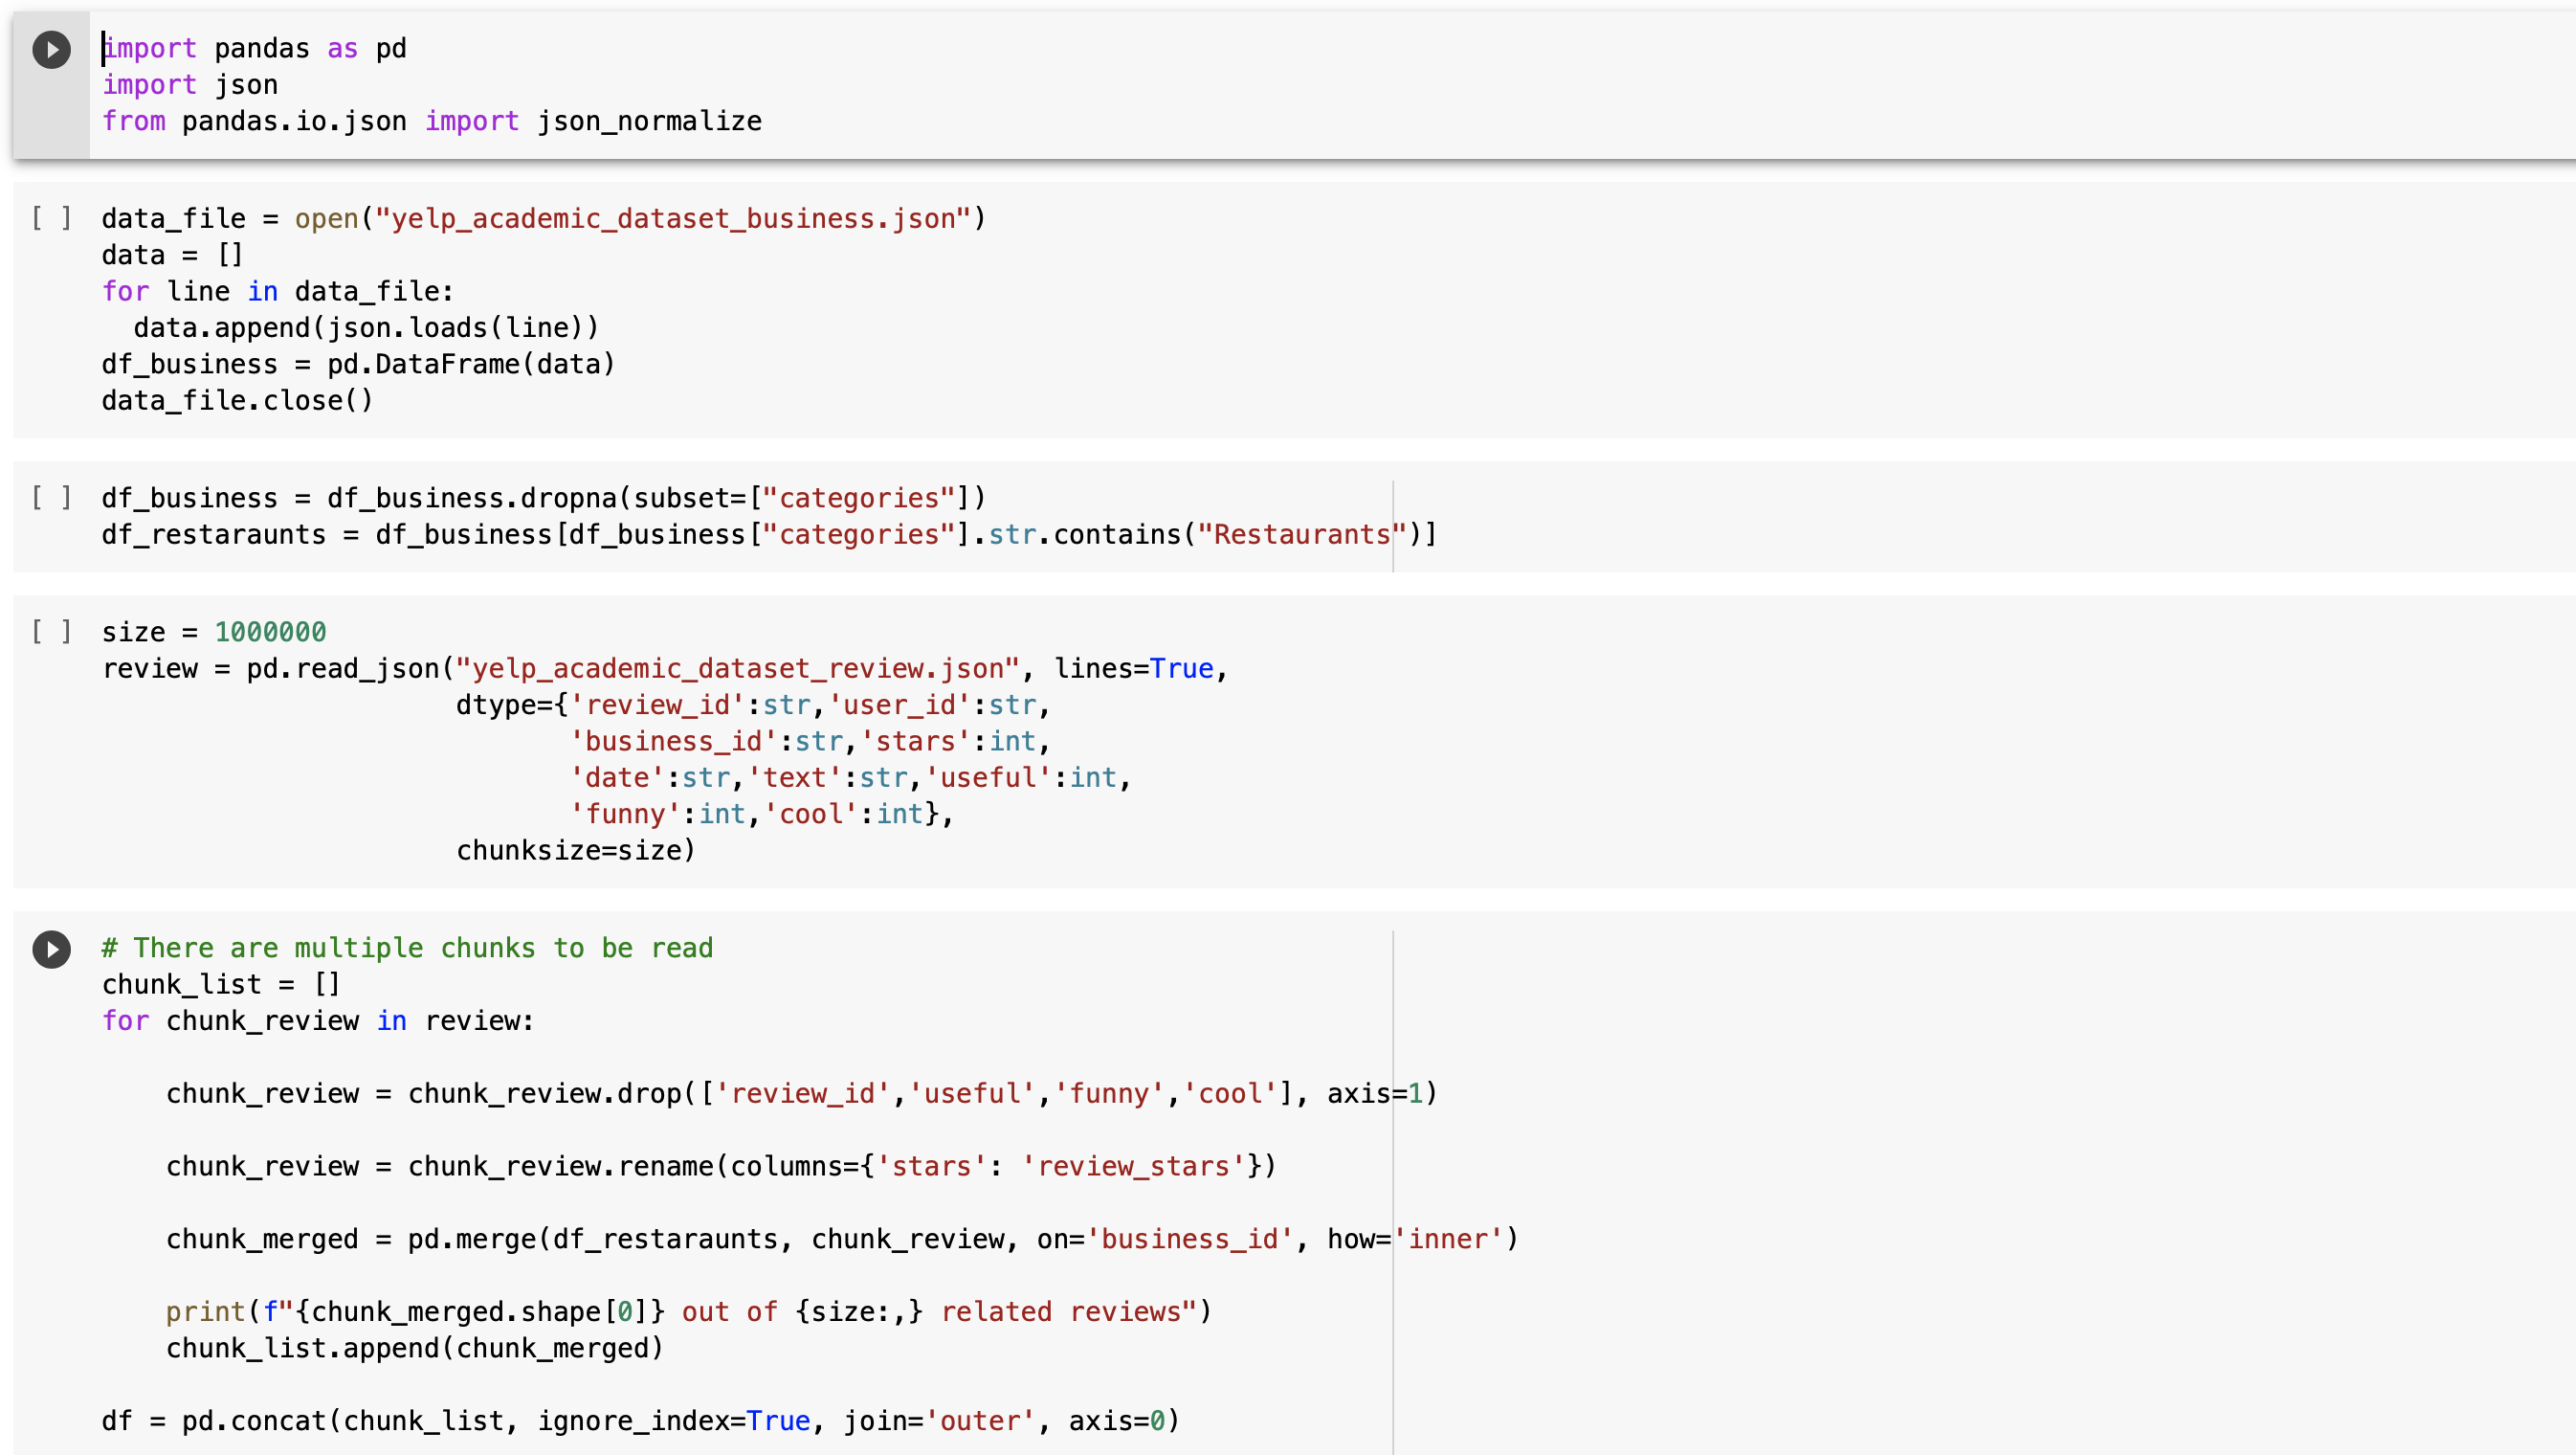

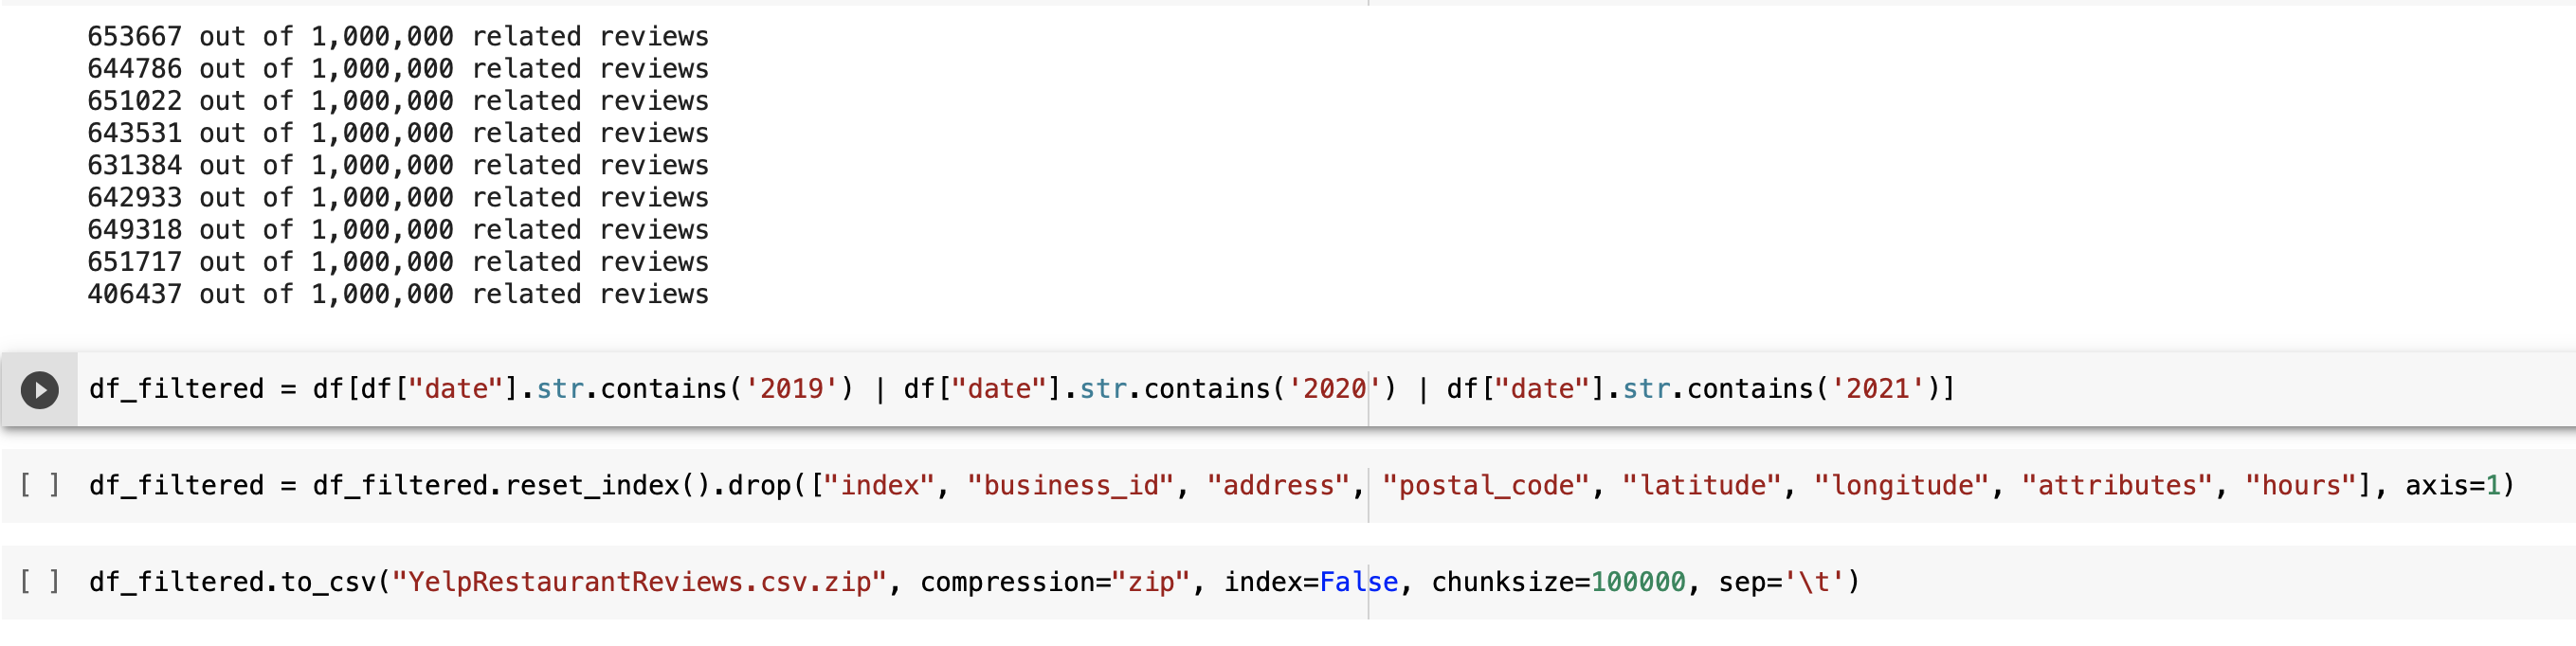

The code in the picture above accomplishes filtering the businesses in the bussiness.json file for restaurants and mapping the businessID’s associated with these restaurants reviews in the reviews.json file. Since the reviews.json file was very large, we needed to complete this operation in chunks of 1,000,000 reviews (9 chunks total). Once we had the reviews data filtered for businesses in the restaraunt category, we dropped all reviews prior to 2019 and many unneeded columns.



**------------------------------------------------------------------------------------------------------------------------------------------------------------**



In [10]:
reviewsIterator = pd.read_csv("/content/drive/MyDrive/DATA 301 Final Project Group 2/YelpRestaurantReviews.csv", iterator=True, low_memory=False)
df_reviews = reviewsIterator.get_chunk()

In [11]:
df_reviews.head()

,name,city,state,stars,review_count,is_open,categories,user_id,review_stars,text,date
0,Oskar Blues Taproom,Boulder,CO,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B...",TeeYMr7BRGdRFBA34UvYmg,1,"Terrible staff, terrible atmosphere, multiple ...",2019-07-06 22:00:54
1,Oskar Blues Taproom,Boulder,CO,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B...",fp2Ex5K_JFfgv2sp5b3ojQ,5,"A great place, great value (often you can get ...",2019-04-06 04:24:21
2,Oskar Blues Taproom,Boulder,CO,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B...",OKHxy3FqkqEhhbQ2uyHEuA,1,If the staff were slightly more friendly and/o...,2021-01-22 05:20:38
3,Oskar Blues Taproom,Boulder,CO,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B...",xyfoFRwV-j98XIERuWhjgA,5,"Friendly service, great beer selection (both o...",2019-04-29 07:26:43
4,Oskar Blues Taproom,Boulder,CO,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B...",CkezvOA8xHzJy85TDJ9nig,5,Vibe is awesome. One of few bars in town with ...,2020-01-12 00:43:38
